In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

Loaded dataset: 1653 rows, 14 columns
Aggregated: 1653 unique work zone records

Low-variance columns <0.01:
avg_precip_in    0.000068
dtype: float32
Dropping low-variance columns: ['avg_precip_in']
Removed 1434 duplicate feature rows; 219 remain.

Regularized Baseline  AUC=0.933,  F1=0.833
StratifiedKFold CV AUCs: [0.931 0.898 0.921 0.974 0.828]
Mean CV AUC: 0.910 plus or minus 0.048


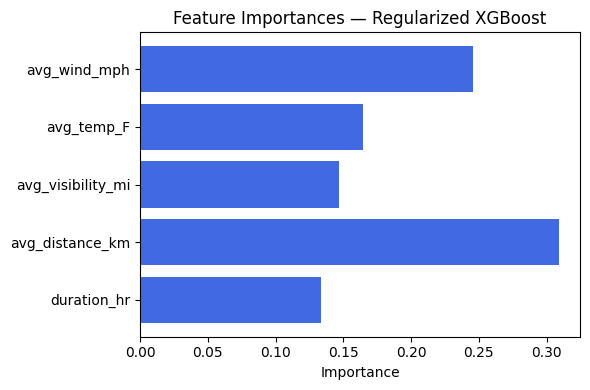

Baseline AUC: 0.933
Cross-val AUC: 0.910  plus or minus 0.048
Low-variance drop: 1 column(s)
Duplicate removal : 1434 rows removed


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data_path = "/work/siads_699_mads_capstone/data/models/workzone_features.csv"
df = pd.read_csv(data_path)
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

def clean_bracketed(val):
    if isinstance(val, str):
        val = val.strip("[]")
        try:
            return float(val)
        except:
            return np.nan
    return val

for c in df.columns:
    if df[c].dtype == "object" and c not in ["road_event_id", "road_name", "vehicle_impact"]:
        df[c] = df[c].apply(clean_bracketed)

agg_cols = [
    'duration_hr','avg_distance_km','avg_visibility_mi','avg_precip_in',
    'avg_temp_F','avg_wind_mph','crash_count','high_risk'
]
existing_cols = [c for c in agg_cols if c in df.columns]
agg_dict = {c: 'mean' for c in existing_cols if c not in ['crash_count','high_risk']}
if 'crash_count' in existing_cols:
    agg_dict['crash_count'] = 'sum'
if 'high_risk' in existing_cols:
    agg_dict['high_risk'] = 'max'
df_unique = df.groupby('road_event_id', as_index=False)[existing_cols].agg(agg_dict)
print(f"Aggregated: {df_unique.shape[0]} unique work zone records")

feature_cols_all = [
    'duration_hr','avg_distance_km','avg_visibility_mi',
    'avg_precip_in','avg_temp_F','avg_wind_mph'
]
feature_cols = [f for f in feature_cols_all if f in df_unique.columns]
X = df_unique[feature_cols].fillna(0).astype(np.float32)
y = df_unique['high_risk'].astype(int).reset_index(drop=True)

var_series = X.var().sort_values()
low_var = var_series[var_series < 0.01]
print("\nLow-variance columns <0.01:")
print(low_var if not low_var.empty else "None")
cols_to_drop = [c for c in low_var.index if c in X.columns]
if len(cols_to_drop) > 0:
    print(f"Dropping low-variance columns: {cols_to_drop}")
    X = X.drop(columns=cols_to_drop, errors="ignore")
combined = pd.concat([X, y], axis=1)
before = len(combined)
combined = combined.drop_duplicates(subset=X.columns.tolist())
after = len(combined)
print(f"Removed {before - after} duplicate feature rows; {after} remain.")

X = combined[X.columns]
y = combined['high_risk']
xgb_reg = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.3,   
    reg_lambda=1.0,  
    eval_metric="auc",
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict_proba(X_test)[:, 1]
auc_base = roc_auc_score(y_test, y_pred)
f1_base = f1_score(y_test, (y_pred > 0.5).astype(int))
print(f"\nRegularized Baseline  AUC={auc_base:.3f},  F1={f1_base:.3f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_aucs = cross_val_score(xgb_reg, X, y, cv=skf, scoring='roc_auc')
print("StratifiedKFold CV AUCs:", np.round(cv_aucs,3))
print(f"Mean CV AUC: {cv_aucs.mean():.3f} plus or minus {cv_aucs.std():.3f}")

importances = xgb_reg.feature_importances_
plt.figure(figsize=(6,4))
plt.barh(X.columns, importances, color="royalblue")
plt.xlabel("Importance")
plt.title("Feature Importances — Regularized XGBoost")
plt.tight_layout()
plt.show()

print(f"Baseline AUC: {auc_base:.3f}")
print(f"Cross-val AUC: {cv_aucs.mean():.3f}  plus or minus {cv_aucs.std():.3f}")
print(f"Low-variance drop: {len(cols_to_drop)} column(s)")
print(f"Duplicate removal : {before - after} rows removed")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>